         TransactionId         BatchId       AccountId       SubscriptionId  \
0  TransactionId_76871   BatchId_36123  AccountId_3957   SubscriptionId_887   
1  TransactionId_73770   BatchId_15642  AccountId_4841  SubscriptionId_3829   
2  TransactionId_26203   BatchId_53941  AccountId_4229   SubscriptionId_222   
3    TransactionId_380  BatchId_102363   AccountId_648  SubscriptionId_2185   
4  TransactionId_28195   BatchId_38780  AccountId_4841  SubscriptionId_3829   

        CustomerId CurrencyCode  CountryCode    ProviderId     ProductId  \
0  CustomerId_4406          UGX          256  ProviderId_6  ProductId_10   
1  CustomerId_4406          UGX          256  ProviderId_4   ProductId_6   
2  CustomerId_4683          UGX          256  ProviderId_6   ProductId_1   
3   CustomerId_988          UGX          256  ProviderId_1  ProductId_21   
4   CustomerId_988          UGX          256  ProviderId_4   ProductId_6   

      ProductCategory    ChannelId   Amount  Value  TransactionStart

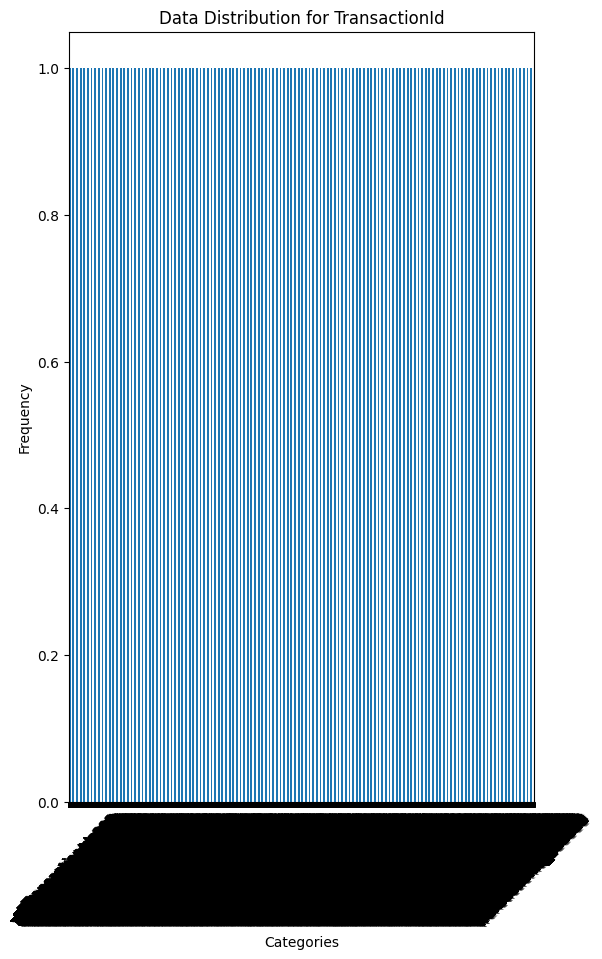

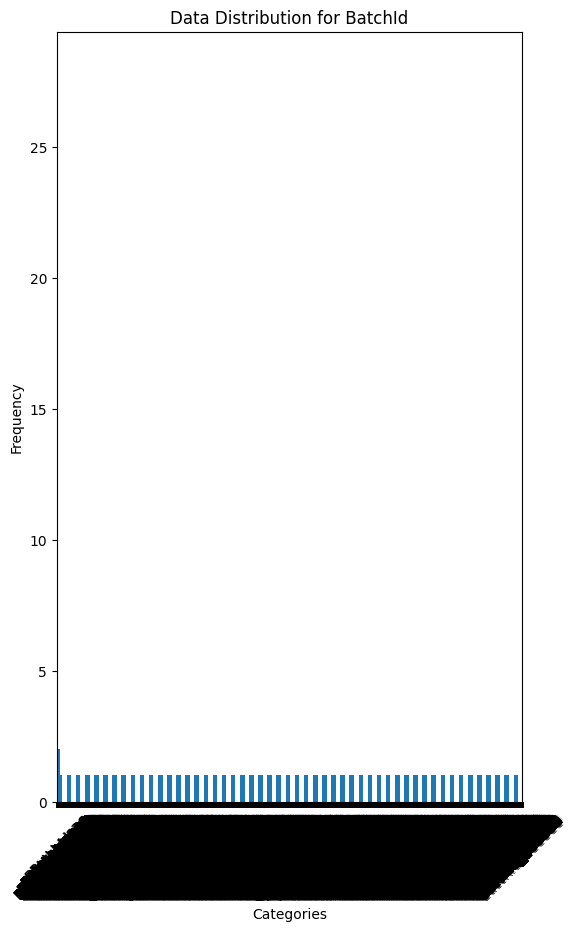

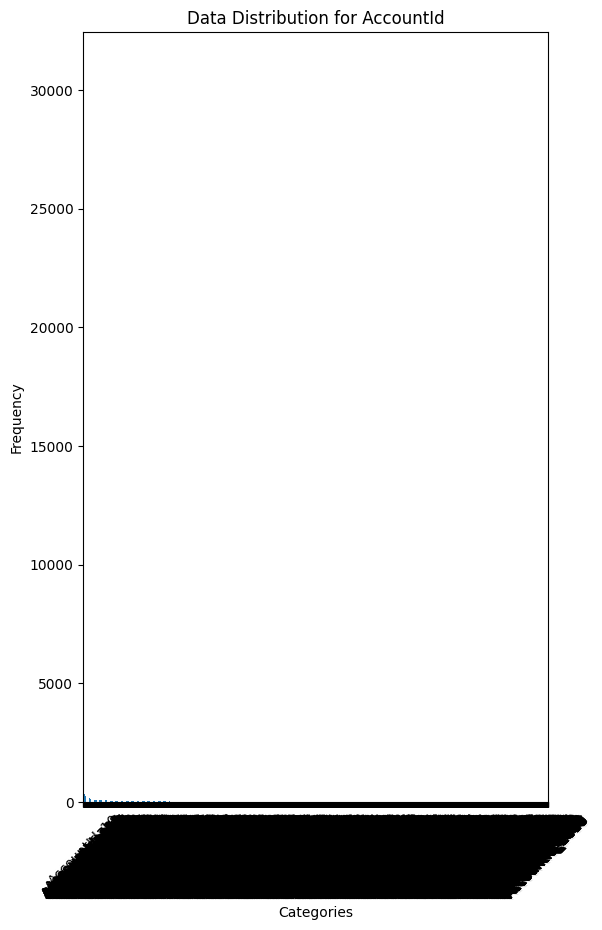

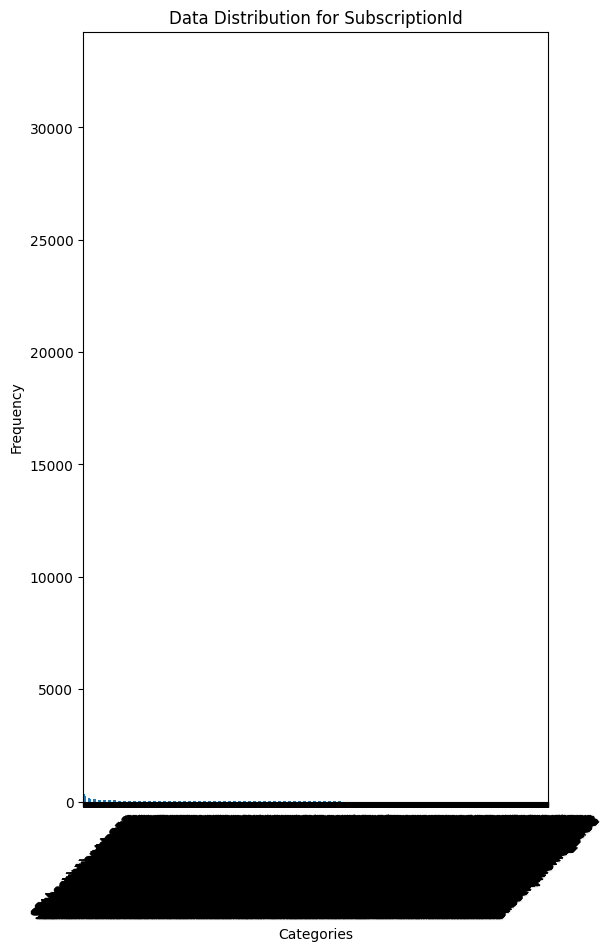

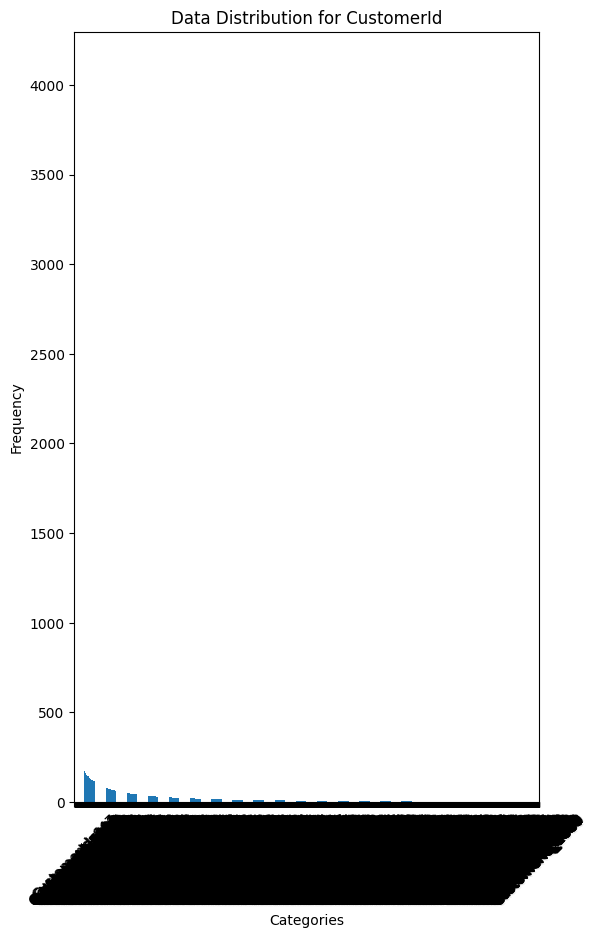

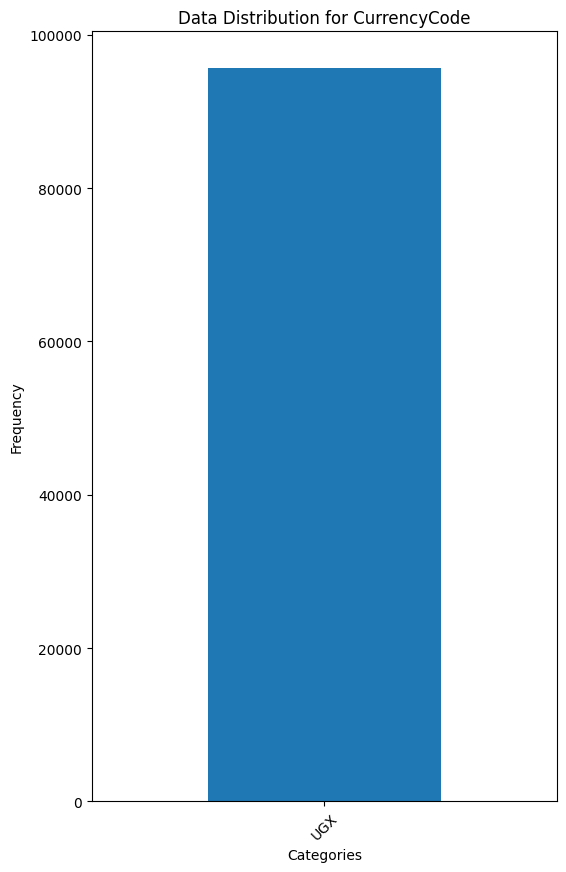

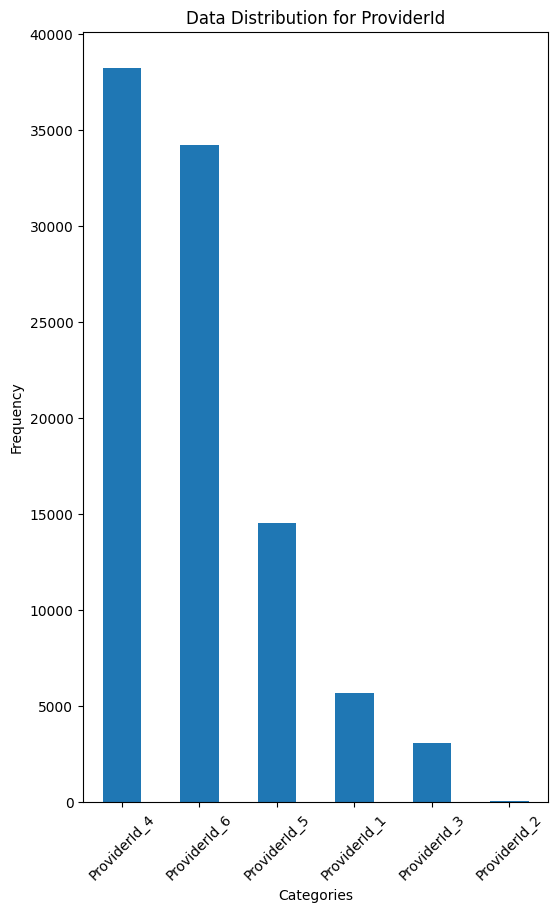

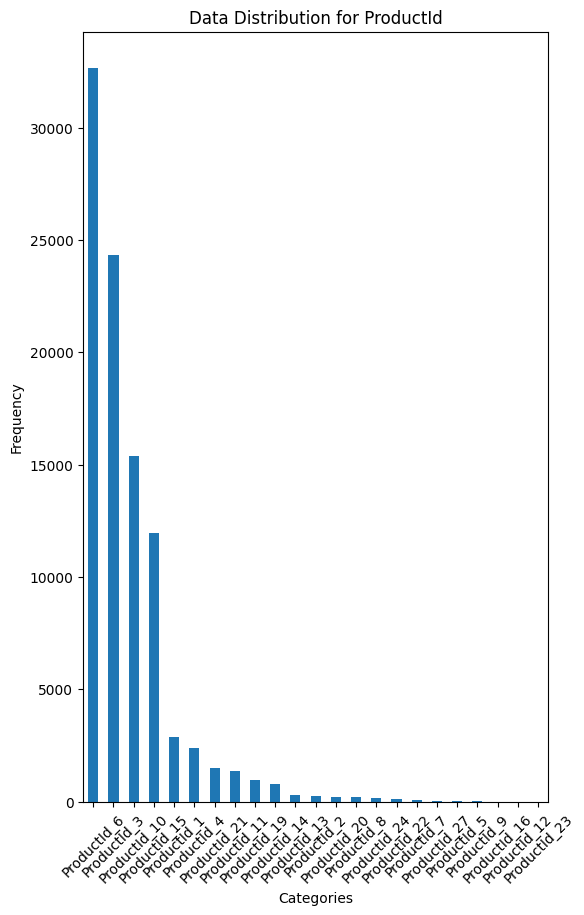

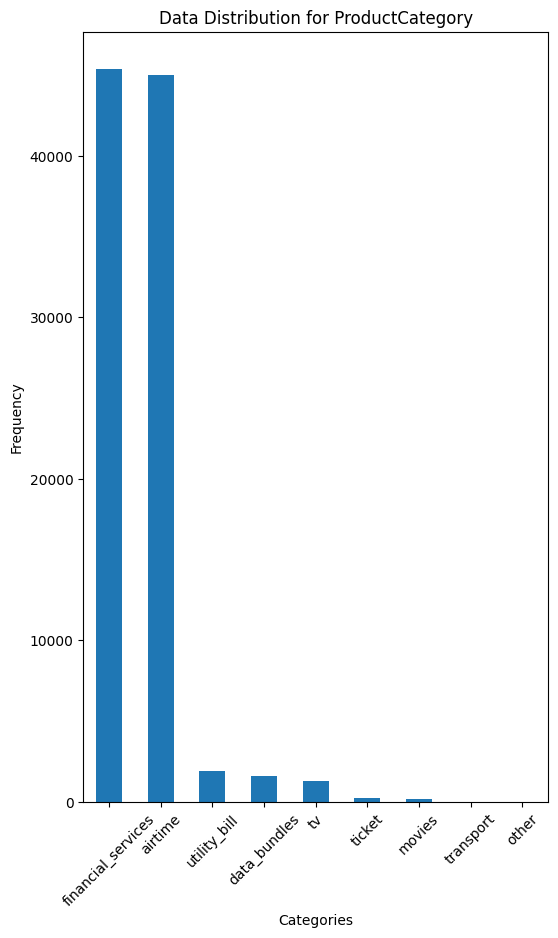

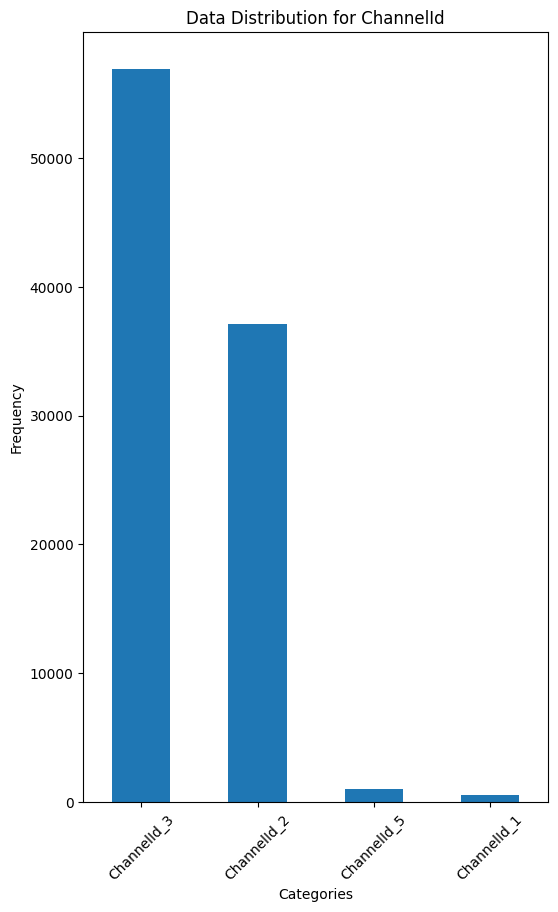

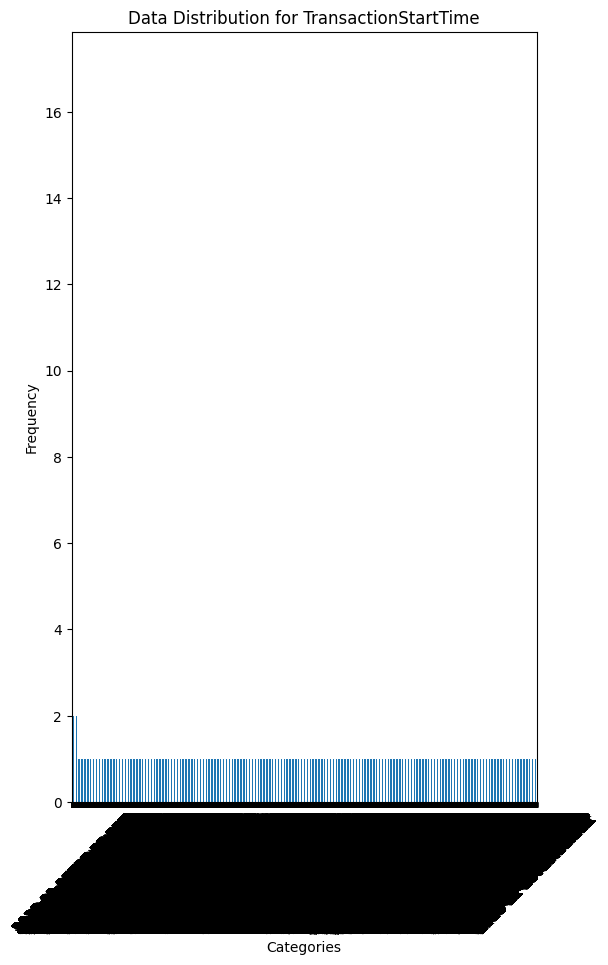

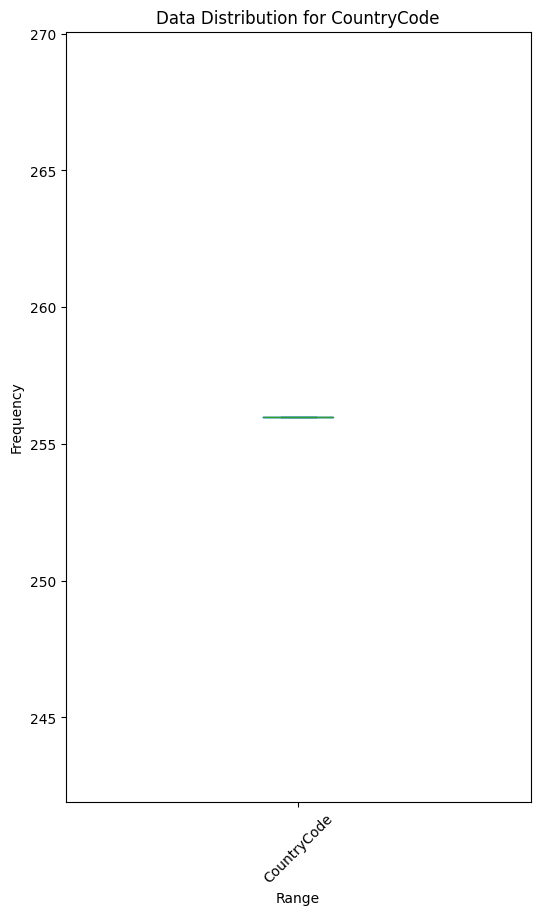

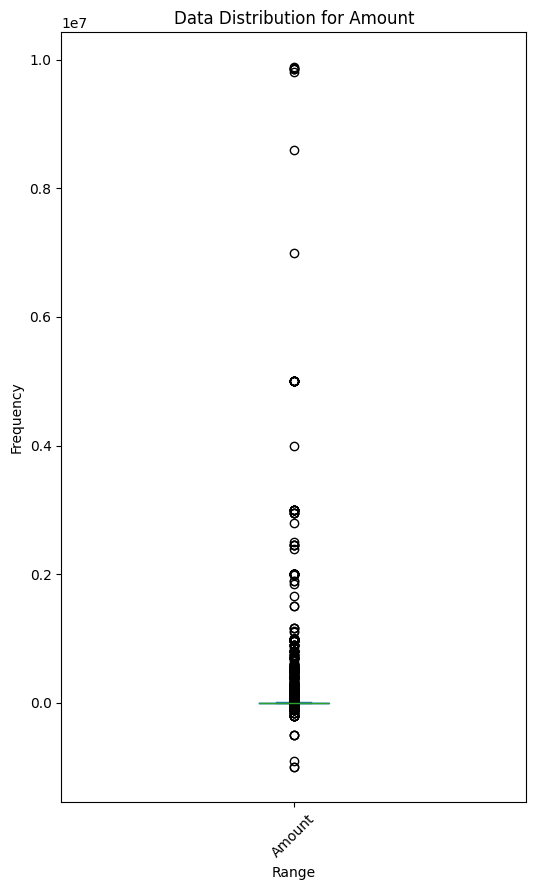

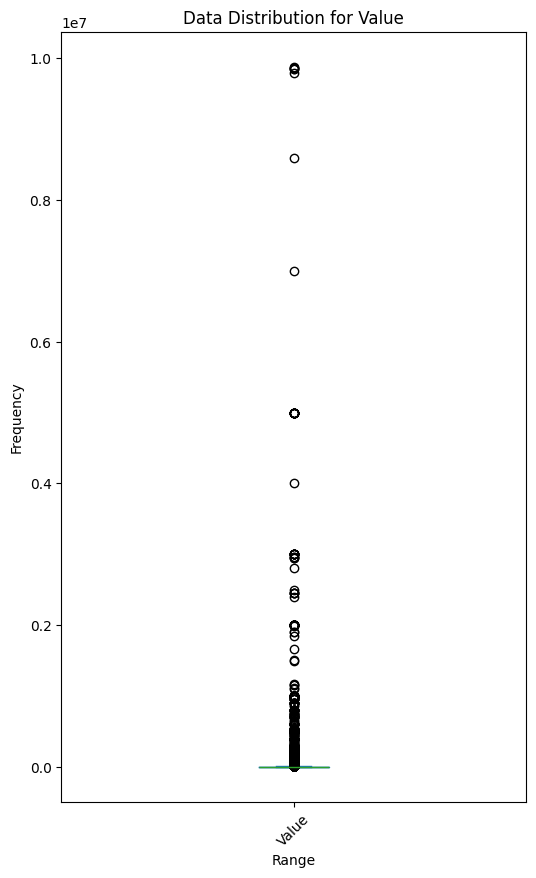

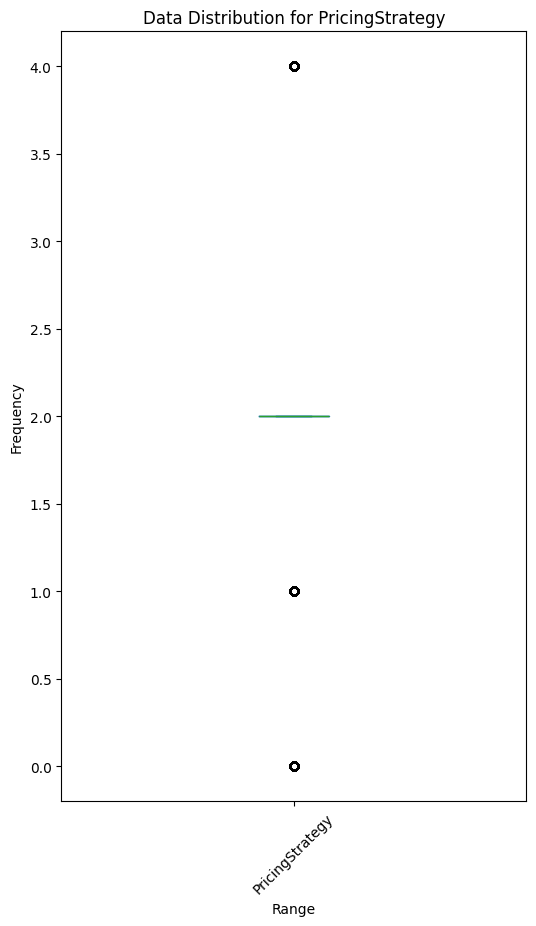

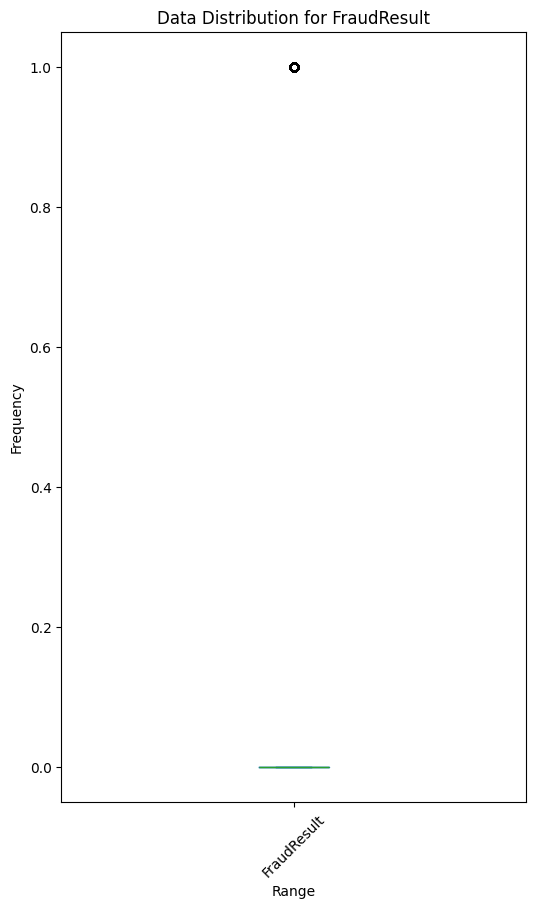

Mean of CountryCode 256.0
Median of CountryCode 256.0
Mode of CountryCode 0    256
Name: CountryCode, dtype: int64
Mean of Amount 6717.846433275491
Median of Amount 1000.0
Mode of Amount 0    1000.0
Name: Amount, dtype: float64
Mean of Value 9900.583941376932
Median of Value 1000.0
Mode of Value 0    1000
Name: Value, dtype: int64
Mean of PricingStrategy 2.25597415901821
Median of PricingStrategy 2.0
Mode of PricingStrategy 0    2
Name: PricingStrategy, dtype: int64
Mean of FraudResult 0.00201752001839811
Median of FraudResult 0.0
Mode of FraudResult 0    0
Name: FraudResult, dtype: int64
Varience of CountryCode 0.0
Standared Divation of CountryCode 0.0
Rang of CountryCode 0
IQR of CountryCode 0.0
leave as it is
Varience of Amount 15204566226.927313
Standared Divation of Amount 123306.79716433848
Rang of Amount 10880000.0
IQR of Amount 2850.0
replaced
Varience of Value 15159048498.369589
Standared Divation of Value 123122.08777619712
Rang of Value 9879998
IQR of Value 4725.0
replaced
V

In [2]:
%run EDA.ipynb

In [2]:
print(framed_data.head())

         TransactionId         BatchId       AccountId       SubscriptionId  \
0  TransactionId_76871   BatchId_36123  AccountId_3957   SubscriptionId_887   
1  TransactionId_73770   BatchId_15642  AccountId_4841  SubscriptionId_3829   
2  TransactionId_26203   BatchId_53941  AccountId_4229   SubscriptionId_222   
3    TransactionId_380  BatchId_102363   AccountId_648  SubscriptionId_2185   
4  TransactionId_28195   BatchId_38780  AccountId_4841  SubscriptionId_3829   

        CustomerId CurrencyCode  CountryCode    ProviderId     ProductId  \
0  CustomerId_4406          UGX          256  ProviderId_6  ProductId_10   
1  CustomerId_4406          UGX          256  ProviderId_4   ProductId_6   
2  CustomerId_4683          UGX          256  ProviderId_6   ProductId_1   
3   CustomerId_988          UGX          256  ProviderId_1  ProductId_21   
4   CustomerId_988          UGX          256  ProviderId_4   ProductId_6   

      ProductCategory    ChannelId       Amount        Value  \
0   

In [4]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Assuming framed_data is your dataframe
categorical_data = framed_data.select_dtypes(include='object').columns

# Use Label Encoding for high-cardinality columns
label_encoder = LabelEncoder()
for col in categorical_data:
    unique_values = framed_data[col].nunique()
    if unique_values > 100:  # Set a threshold for large cardinality
        framed_data[col] = label_encoder.fit_transform(framed_data[col])
    else:
        # Use one-hot encoding for lower cardinality columns
        framed_data = pd.get_dummies(framed_data, columns=[col], drop_first=True)


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import woe

# Convert TransactionStartTime to datetime
framed_data['TransactionStartTime'] = pd.to_datetime(framed_data['TransactionStartTime'])


In [56]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Ensure TransactionStartTime is in datetime format
framed_data['TransactionStartTime'] = pd.to_datetime(framed_data['TransactionStartTime'])

# Calculate Recency (R) - the number of days since the customer's last transaction
latest_transaction = framed_data['TransactionStartTime'].max()
framed_data['Recency'] = (latest_transaction - framed_data['TransactionStartTime']).dt.days

# Calculate Frequency (F) - the total number of transactions for each customer
frequency = framed_data.groupby('CustomerId')['TransactionId'].count().reset_index()
frequency.columns = ['CustomerId', 'Frequency']

# Calculate Monetary Value (M) - the total amount spent by each customer
monetary = framed_data.groupby('CustomerId')['Amount'].sum().reset_index()
monetary.columns = ['CustomerId', 'Monetary']

# Merge Recency, Frequency, and Monetary into a single DataFrame (rfm)
rfm = pd.merge(frequency, monetary, on='CustomerId')
rfm = pd.merge(rfm, framed_data[['CustomerId', 'Recency']].drop_duplicates(), on='CustomerId')

# Scale the Recency, Frequency, and Monetary values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Use KMeans clustering to classify customers into two clusters: 'Good' and 'Bad'
kmeans = KMeans(n_clusters=2, random_state=42)  # 2 clusters
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Map the clusters to labels: 'Good' or 'Bad'
rfm['Label'] = rfm['Cluster'].map({0: 'Bad', 1: 'Good'})  # Adjust the mapping if necessary

# Drop overlapping columns from rfm to avoid conflicts
rfm.drop(columns=['Cluster', 'Recency'], inplace=True)  # Drop Cluster if you don't want duplicates

# Merge the rfm DataFrame with the original framed_data on 'CustomerId'
framed_data = pd.merge(framed_data, rfm[['CustomerId', 'Frequency', 'Monetary', 'Label']], on='CustomerId', how='left', suffixes=('', '_y'))

# Optionally drop the redundant columns from the merge if they exist
framed_data.drop(columns=[col for col in framed_data.columns if col.endswith('_y')], inplace=True, errors='ignore')

# Display the updated framed_data DataFrame
print(framed_data.head())


   TransactionId  BatchId  AccountId  SubscriptionId  CustomerId  CountryCode  \
0          78150    46980       2490            3535        2584          256   
1          75821    31755       3219            2366        2584          256   
2          39888    60272       2713             996        2806          256   
3          48738     1797       3351             974        3733          256   
4          41364    48941       3219            2366        3733          256   

        Amount        Value          TransactionStartTime  PricingStrategy  \
0  6717.846433  9900.583941 1970-01-01 00:00:00.000000000         2.255974   
1  6717.846433  9900.583941 1970-01-01 00:00:00.000000001         2.255974   
2  6717.846433  9900.583941 1970-01-01 00:00:00.000000002         2.255974   
3  6717.846433  9900.583941 1970-01-01 00:00:00.000000003         2.255974   
4  6717.846433  9900.583941 1970-01-01 00:00:00.000000004         2.255974   

   ...  Recency_x  Frequency_x     Monetary_

In [58]:
import scorecardpy as sc

# Ensure your Label column is numeric
rfm['Label'] = rfm['Label'].map({'Good': 1, 'Bad': 0})  # Adjust the mapping accordingly

# Specify the positive class based on the new mapping
bins = sc.woebin(rfm, y='Label', positive=1)  # 1 corresponds to 'Good'

# Apply the WoE bins to the dataset
rfm_woe = sc.woebin_ply(rfm, bins)

# Display the WoE transformed data
print(rfm_woe.head())


[INFO] creating woe binning ...


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\scorecardpy\condition_fun.py:34: UserWarning: There are 1 columns have only one unique values, which are removed from input dataset. 
 (ColumnNames: Recency)
  warnings.warn("There are {} columns have only one unique values, which are removed from input dataset. \n (ColumnNames: {})".format(len(unique1_cols), ', '.join(unique1_cols)))
C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will ra

[INFO] converting into woe values ...
   Recency  Label  Monetary_woe  Frequency_woe  CustomerId_woe  Cluster_woe
0        0      0           0.0            0.0       -0.654846          0.0
1        0      0           0.0            0.0       -0.654846          0.0
2        0      0           0.0            0.0       -0.654846          0.0
3        0      0           0.0            0.0       -0.654846          0.0
4        0      0           0.0            0.0       -0.654846          0.0


In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split
X = framed_data.drop('Label', axis=1)  
y = framed_data['Label']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Ensure TransactionStartTime is in datetime format
framed_data['TransactionStartTime'] = pd.to_datetime(framed_data['TransactionStartTime'])

# Calculate Recency (R) - the number of days since the customer's last transaction
latest_transaction = framed_data['TransactionStartTime'].max()
framed_data['Recency'] = (latest_transaction - framed_data['TransactionStartTime']).dt.days

# Calculate Frequency (F) - the total number of transactions for each customer
frequency = framed_data.groupby('CustomerId')['TransactionId'].count().reset_index()
frequency.columns = ['CustomerId', 'Frequency']

# Calculate Monetary Value (M) - the total amount spent by each customer
monetary = framed_data.groupby('CustomerId')['Amount'].sum().reset_index()
monetary.columns = ['CustomerId', 'Monetary']

# Merge Recency, Frequency, and Monetary into a single DataFrame (rfm)
rfm = pd.merge(frequency, monetary, on='CustomerId')
rfm = pd.merge(rfm, framed_data[['CustomerId', 'Recency']].drop_duplicates(), on='CustomerId')

# Scale the Recency, Frequency, and Monetary values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Use KMeans clustering to classify customers into two clusters: 'Good' and 'Bad'
kmeans = KMeans(n_clusters=2, random_state=42)  # 2 clusters
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Map the clusters to labels: 'Good' or 'Bad'
rfm['Label'] = rfm['Cluster'].map({0: 'Bad', 1: 'Good'})  # Adjust the mapping if necessary

# Rename columns in rfm to avoid conflicts during merge
rfm.rename(columns={
    'Recency': 'Recency_rfm',
    'Frequency': 'Frequency_rfm',
    'Monetary': 'Monetary_rfm',
    'Cluster': 'Cluster_rfm',
    'Label': 'Label_rfm'
}, inplace=True)

# Merge the rfm DataFrame with the original framed_data on 'CustomerId'
framed_data = pd.merge(framed_data, rfm[['CustomerId', 'Recency_rfm', 'Frequency_rfm', 'Monetary_rfm', 'Cluster_rfm', 'Label_rfm']], on='CustomerId', how='left')

# Display the updated framed_data DataFrame
print(framed_data.head())


   TransactionId  BatchId  AccountId  SubscriptionId  CustomerId  CountryCode  \
0          78150    46980       2490            3535        2584          256   
1          75821    31755       3219            2366        2584          256   
2          39888    60272       2713             996        2806          256   
3          48738     1797       3351             974        3733          256   
4          41364    48941       3219            2366        3733          256   

        Amount        Value          TransactionStartTime  PricingStrategy  \
0  6717.846433  9900.583941 1970-01-01 00:00:00.000000000         2.255974   
1  6717.846433  9900.583941 1970-01-01 00:00:00.000000001         2.255974   
2  6717.846433  9900.583941 1970-01-01 00:00:00.000000002         2.255974   
3  6717.846433  9900.583941 1970-01-01 00:00:00.000000003         2.255974   
4  6717.846433  9900.583941 1970-01-01 00:00:00.000000004         2.255974   

   ...  Frequency       Monetary  Cluster  L

Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

         Bad       1.00      1.00      1.00     17511
        Good       1.00      1.00      1.00      1622

    accuracy                           1.00     19133
   macro avg       1.00      1.00      1.00     19133
weighted avg       1.00      1.00      1.00     19133



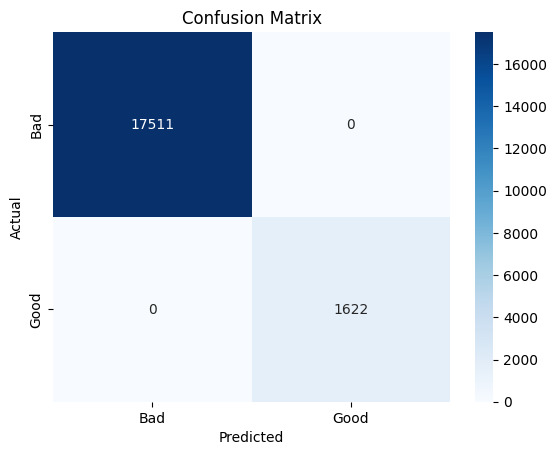

In [65]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming framed_data is already prepared and contains the necessary features and labels

# Step 1: Prepare your features and labels
# Drop the 'Label' and non-numeric columns from the features
X = framed_data.drop(columns=['Label', 'TransactionId', 'TransactionStartTime', 
                              'CustomerId', 'AccountId', 'BatchId', 
                              'SubscriptionId', 'ProviderId', 
                              'ProductId', 'ProductCategory', 
                              'ChannelId', 'CurrencyCode', 
                              'CountryCode'], errors='ignore')  # Features

# Convert categorical columns to numeric using one-hot encoding or label encoding
X = pd.get_dummies(X, drop_first=True)

y = framed_data['Label']  # Target variable

# Step 2: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize the Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Step 4: Train the classifier
gb_classifier.fit(X_train, y_train)

# Step 5: Make predictions on the test set
y_pred = gb_classifier.predict(X_test)

# Step 6: Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
